# Test discovery and data access using DaCHS and a standalone Datalink service

## Description

This notebook illustrates example data discovery via an IVOA simple cone search (SCS) [1] and subsequent SODA processing (cutout) using real data in datalake.

As part of the discovery process, an `access_url` pointing to an IVOA Datalink service [2] is used to reveal physical data locations to the client. This datalink service talks to Rucio via its api, and in its default mode (`nearest_by_client`) gets the nearest replica location by calculating the shortest available great circle distance between the geolocated client's ip and the sites holding replicas. Alternatively, it is possible to get a random replica by adding the query parameter `sort=random` to the datalink query url.

Site information (lat/long) is retrieved by calls to a [site-directory](https://gitlab.com/ska-telescope/src/src-site-directory/-/tree/main/src/site_directory) api.

[1] [https://www.ivoa.net/documents/latest/ConeSearch.html](https://www.ivoa.net/documents/latest/ConeSearch.html)
[2] [https://www.ivoa.net/documents/DataLink/](https://www.ivoa.net/documents/latest/ConeSearch.html)

## Prerequisites

1. It is assumed that the entry to search for has already had a corresponding record added into the Rucio metadata database. This entry must have valid `s_ra`, `s_dec` and `access_url` fields in the JSON data column, where the `access_url` points to a datalink resource with the did as the `id` parameter, e.g. `https://ivoa.datalink.srcdev.skao.int/rucio/links?id=testing:PTF10tce.fits`. Note that the datalink service uri must be resolvable from the machine that is making the query. If using this prototype, this is probably a jupyter instance running inside another container on the same docker network, in which case it must be the container name. If running a separate jupyter instance from outside the docker network, the datalink service must be made externally accessible (unless running from the host of the docker network, in which case you can expose the datalink port & use `localhost`).

2. An instance of site-directory must be running in order to use the datalink service in `nearest_by_client` mode.
3. The user must have a valid account on the Rucio datalake.
4. There must be a SODA service colocated with the RSE and a corresponding entry in site-directory for the site.



## Query a DaCHS SCS service around some coordinates

In [105]:
from pyvo.dal import conesearch

results = conesearch("https://ivoa.dachs.srcdev.skao.int/rucio/rucio/cone/scs.xml", pos=(53.753, -24.933), radius=1)
results.to_table()['_r', 'obs_id', 's_ra', 's_dec', 'access_url', 'access_format']

_r,obs_id,s_ra,s_dec,access_url,access_format
deg,,deg,deg,,
float64,object,float64,float64,object,object
0.0006540356412499768,Eridanus_cutout_NGC1436,53.75308,-24.93365,https://ivoa.datalink.srcdev.skao.int/rucio/links?id=sp3531_soda:2023-07-18-16-40-27_ASK-WALLABY_Eridanus_cutout-574594-imagecube-42178.fits,application/x-votable+xml;content=datalink
0.0006540356412499768,Eridanus_full_image,53.75308,-24.93365,https://ivoa.datalink.srcdev.skao.int/rucio/links?id=orange:2023-\n07-10-17-21-37_cutout-574594-imagecube-42178.fits,application/x-votable+xml;content=datalink
0.5700196618808213,RACS-DR1_0337-25A,54.340616250000004,-25.136623999999998,https://ivoa.datalink.srcdev.skao.int/rucio/links?id=testing_ingest_180723:001_RACS-DR1_0337-25A,application/x-votable+xml;content=datalink


## Get an access url from the Datalink resource

This datalink resource retrieves the list of possible replicas for this DID using Rucio's REST interface, and returns the nearest replica to the client's geolocated IP address.

In [106]:
import requests

from pyvo.dal.adhoc import DatalinkResults

# use first result
result = results[0]

# get the datalink access url for this first result
datalink_access_url = result['access_url']

did = datalink_access_url.split('id=')[1]
scope, name = did.split(':')

# go get the information from the datalink service (we explicitly state a client IP address, otherwise it tries to resolve localhost)
# and enforce that a SODA service must exist at the site hosting the replica
datalink = DatalinkResults.from_result_url("{}&client_ip_address=130.246.210.120&must_include_soda=True".format(datalink_access_url))

datalink.to_table()

ID,access_url,service_def,error_message,semantics,description,content_type,content_length,content_qualifier
,,,,,,,byte,
object,object,object,object,object,object,object,int64,object
ivo://auth.example.org/datasets/fits?sp3531_soda/9b/98/2023-07-18-16-40-27_ASK-WALLABY_Eridanus_cutout-574594-imagecube-42178.fits,https://spsrc14.iaa.csic.es:18027/disk/dev/deterministic/sp3531_soda/9b/98/2023-07-18-16-40-27_ASK-WALLABY_Eridanus_cutout-574594-imagecube-42178.fits,,,#this,Eridanus_cutout_NGC1436,,--,
ivo://auth.example.org/datasets/fits?sp3531_soda/9b/98/2023-07-18-16-40-27_ASK-WALLABY_Eridanus_cutout-574594-imagecube-42178.fits,,soda-sync,,#cutout,SODA-sync cutout of ivo://auth.example.org/datasets/fits?sp3531_soda/9b/98/2023-07-18-16-40-27_ASK-WALLABY_Eridanus_cutout-574594-imagecube-42178.fits,,--,
ivo://auth.example.org/datasets/fits?sp3531_soda/9b/98/2023-07-18-16-40-27_ASK-WALLABY_Eridanus_cutout-574594-imagecube-42178.fits,,soda-async,,#cutout,SODA-async cutout of ivo://auth.example.org/datasets/fits?sp3531_soda/9b/98/2023-07-18-16-40-27_ASK-WALLABY_Eridanus_cutout-574594-imagecube-42178.fits,,--,


## Access the data

In this case, we make a GET request to the SODA cutout service with the ID and CIRCLE parameters. The SODA service has direct access to storage via a mount point.

Access url:	http://spsrc33.iaa.csic.es:18022/soda
ID:	ivo://auth.example.org/datasets/fits?sp3531_soda/9b/98/2023-07-18-16-40-27_ASK-WALLABY_Eridanus_cutout-574594-imagecube-42178.fits
101916KB downloaded

Filename: 2023-07-18-16-40-27_ASK-WALLABY_Eridanus_cutout-574594-imagecube-42178.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      74   (55, 61, 1, 7776)   float32   


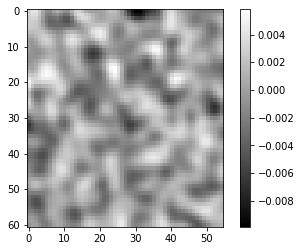

In [113]:
import os

from astropy.io import fits
import pylab as plt
from matplotlib.colors import LogNorm

# take the datalink link with semantic "#cutout
datalink_proc = next(datalink.bysemantics('#cutout'))

# get the SODA access url and ivoid required by SODA from this link
access_url = datalink_proc.access_url
ivoid = datalink_proc.id

print("Access url:\t{}".format(access_url))
print("ID:\t{}".format(ivoid))

# get the SODA response
#response = SodaQuery(datalink_proc.access_url, id=datalink_proc.id, circle=(53.753, -24.933, 0.1))    # doesn't formulate query parameter correctly
response = requests.get("{}?ID={}&CIRCLE={}".format(access_url, ivoid, "53.753 -24.933 0.1", stream=True))
if response.status_code == 200:
    with open(name, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            print("{}KB downloaded".format(round(os.path.getsize(name)/1024), 0), end='\r')
            f.write(chunk)
            f.flush()
    print('\n')

    fits.info(name)

    image_data = fits.getdata(name, ext=0)

    plt.figure()
    plt.imshow(image_data[100,0,::], cmap='gray')
    plt.colorbar()
    plt.show()
else:
    print("error getting data: {}".format(response.status_code))

